In [1]:
import pandas as pd #pandas 1.5.3
import numpy as np

import tensorflow as tf
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.metrics import roc_auc_score
from joblib import load
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer


In [25]:
train.head()

,comment,parent_comment,comment_tokens,parent_comment_tokens,comment_score,parent_comment_score,weighted_parent_sentiment_score_neutral,weighted_parent_sentiment_score_positive,weighted_comment_sentiment_score_neutral,weighted_comment_sentiment_score_positive,...,parent_comment_char_count,comment_punctuation_count,parent_comment_punctuation_count,comment_hashtag_count,parent_comment_hashtag_count,comment_number_count,parent_comment_number_count,comment_tfidf,comment_tfidf_nn,label
224082,am i the only one who is disturbed by the avoc...,here is what you should be counting for weight...,"[one, disturbed, avocado, fridge, ?]","[counting, weight, loss]",-0.3818,-0.3182,0,0,0,0,...,53,1,0,0,0,0,0,"(0, 12628)\t0.5907277137704723\n (0, 17525)...","(0, 3750)\t1.0",0
159968,that is exactly what you do.,you can put companions in power armor?! how di...,"[exactly, .]","[put, companion, power, armor, ?, !, not, know...",0.0000,0.0000,1,0,1,0,...,146,1,5,0,0,0,0,"(0, 15236)\t1.0","(0, 1653)\t1.0",0
76536,relax guys it is 1 hour and 41 minutes,suicide squad running time is not 140 min,"[relax, guy, 1, hour, 41, minute]","[suicide, squad, running, time, not, 140, min]",0.4404,-0.6705,0,0,0,1,...,41,0,0,0,0,2,1,"(0, 695)\t0.581474391928876\n (0, 46776)\t0...","(0, 4390)\t0.6578250440136402\n (0, 2392)\t...",1
42590,"found who has op's ram, get him boys.","that sucks. on the bright side, fedex sent me ...","[found, op, 's, ram, ,, get, boy, .]","[suck, ., bright, side, ,, fedex, sent, free, ...",0.0000,0.5719,0,1,1,0,...,78,3,3,0,0,0,0,"(0, 18795)\t0.5310155011833231\n (0, 45548)...","(0, 4277)\t0.5568708579122882\n (0, 646)\t0...",1
302446,that doocane dude would fucking attack you if ...,mr ex phys thinks 5x5 is bad but loves 10x10 g...,"[doocane, dude, would, fucking, attack, said, ...","[mr, ex, phys, think, 5x5, bad, love, 10x10, g...",0.2040,0.5859,0,1,1,0,...,56,1,4,0,0,0,0,"(0, 62879)\t0.38339935300816974\n (0, 13304...","(0, 3225)\t0.42144921279870756\n (0, 664)\t...",0


In [2]:
train = pd.read_pickle("data/train.pkl")
test = pd.read_pickle("data/test.pkl")
tfidf_vec = load('tdvectorizer_nn.pkl')
y_train = np.array(train['label'])
y_test = np.array(test['label'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
train_tfidf_csr = vstack(train["comment_tfidf_nn"])
test_tfidf_csr = vstack(test["comment_tfidf_nn"])
list_of_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive']
bool_cols = ['weighted_parent_sentiment_score_neutral',
             'weighted_parent_sentiment_score_positive',
             'weighted_comment_sentiment_score_neutral',
             'weighted_comment_sentiment_score_positive']

for col in bool_cols: #need to convert bool type to integer
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)
feature_names = tfidf_vec.get_feature_names_out()
combined_feature_names = list_of_features + list(feature_names)
X_train_gen_features = csr_matrix(train[list_of_features])
X_test_gen_features = csr_matrix(test[list_of_features])
x_train = hstack([X_train_gen_features, train_tfidf_csr]).toarray()
x_test = hstack([X_test_gen_features, test_tfidf_csr]).toarray()



## Feedforward NN
- We have tuned a baseline model using keras tuner, of which the code is below. We managed to achieve about 0.745 AUC at best.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=16, validation_split=0.2)




Epoch 1/20
12075/12075 [==============================] - 23s 2ms/step - loss: 0.6589 - accuracy: 0.6046 - val_loss: 0.6153 - val_accuracy: 0.6585
Epoch 2/20
12075/12075 [==============================] - 22s 2ms/step - loss: 0.6075 - accuracy: 0.6631 - val_loss: 0.6171 - val_accuracy: 0.6472
Epoch 3/20
12075/12075 [==============================] - 22s 2ms/step - loss: 0.5957 - accuracy: 0.6769 - val_loss: 0.5997 - val_accuracy: 0.6683
Epoch 4/20
12075/12075 [==============================] - 21s 2ms/step - loss: 0.5877 - accuracy: 0.6825 - val_loss: 0.5917 - val_accuracy: 0.6788
Epoch 5/20
12075/12075 [==============================] - 21s 2ms/step - loss: 0.5823 - accuracy: 0.6879 - val_loss: 0.5916 - val_accuracy: 0.6781
Epoch 6/20
12075/12075 [==============================] - 21s 2ms/step - loss: 0.5770 - accuracy: 0.6912 - val_loss: 0.5944 - val_accuracy: 0.6753
Epoch 7/20
12075/12075 [==============================] - 22s 2ms/step - loss: 0.5723 - accuracy: 0.6955 - val_loss: 0

In [4]:
from tensorflow.keras.models import load_model
#model.save('data/ffmodel') #save model
ffmodel = load_model('data/ffmodel')

## Visualising ROC AUC curve
- AUC: 0.74531

1887/1887 [==============================] - 2s 889us/step
AUC: 0.7453123776073246


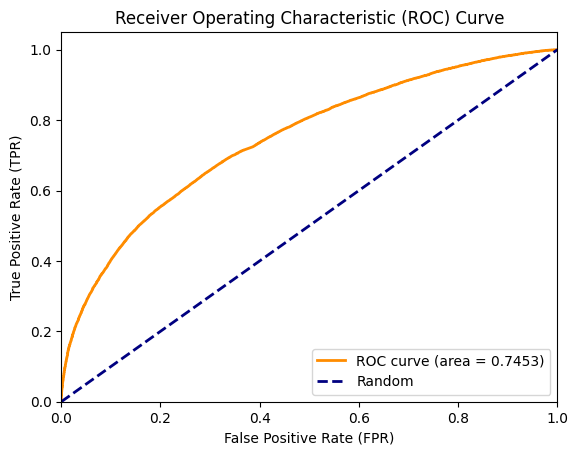

In [5]:
y_pred_test = ffmodel.predict(x_test)
#roc_auc_test = roc_auc_score(y_test, y_pred_test)
#comment td-idf only AUC: 0.6628971516171749
#gen features + comment td-idf AUC: 0.7419122793471202
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr, tpr)
print(f'AUC: {roc_auc_test}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Model Explainability
- Say we want to explain the model for statements 100, 200, 300
- Due to the way the lime explainer perturbs the data on the entire dataset, the lime model selects features that are irrelevant to the document

In [16]:
# Sample a smaller dataset for LIME
#sample_size = 3000  # Adjust this number based on your dataset size and complexity
#lime_train_sample = x_train[np.random.choice(x_train.shape[0], sample_size, replace=False)]#data is too large
lime_train_sample = x_train[:50000] #30000 takes 46s, 50000 takes 1min 41s
# Set up LIME explainer using the sampled data
explainer = LimeTabularExplainer(
    training_data=lime_train_sample,  # Use the sampled data
    feature_names=combined_feature_names,
    class_names=[0, 1],
    discretize_continuous=True,
    sample_around_instance=True
)

# Function to split the combined data back into text and other features
def split_data(combined_data):
    # Assuming the first len(list_of_features) columns are other features
    # and the remaining are text features in TF-IDF format
    other_features_data = combined_data[:, :len(list_of_features)]
    text_data_tfidf = combined_data[:, len(list_of_features):]
    return other_features_data, text_data_tfidf

# Define the prediction function for LIME
def predict_fn(data):
    other_features_data, text_data_tfidf = split_data(data)
    final_data = hstack([csr_matrix(other_features_data), text_data_tfidf]).toarray()

    # Get predictions for one class
    preds = ffmodel.predict(final_data)

    # Convert predictions to two columns (probabilities for both classes)
    # Assuming preds are the probabilities for class 1
    return np.hstack([1 - preds, preds])




1/1 [==============================] - 0s 13ms/step
Document ID: 100
Document content: look, this is why playing the patton with the 105 is viable.
Probability(Sarcastic) = 0.32763457
True class: 0
1/1 [==============================] - 0s 91ms/step
Document ID: 200
Document content: is... is that a metaphor?
Probability(Sarcastic) = 0.40029886
True class: 0
1/1 [==============================] - 0s 50ms/step
Document ID: 300
Document content: i do agree that rusev needs a stand up finisher not just the accolade, as much as i love it.
Probability(Sarcastic) = 0.6581904
True class: 1


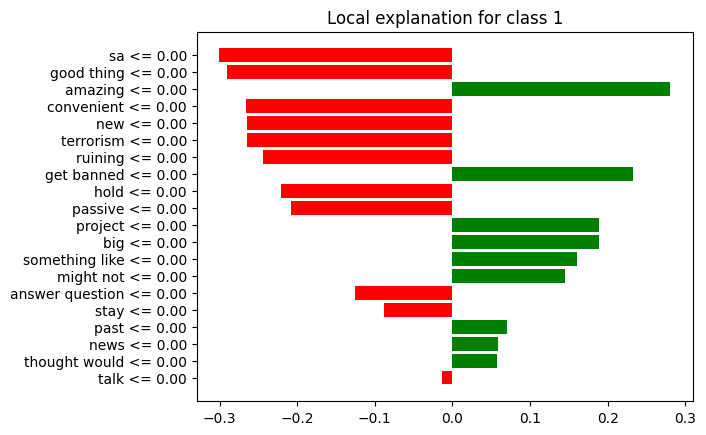

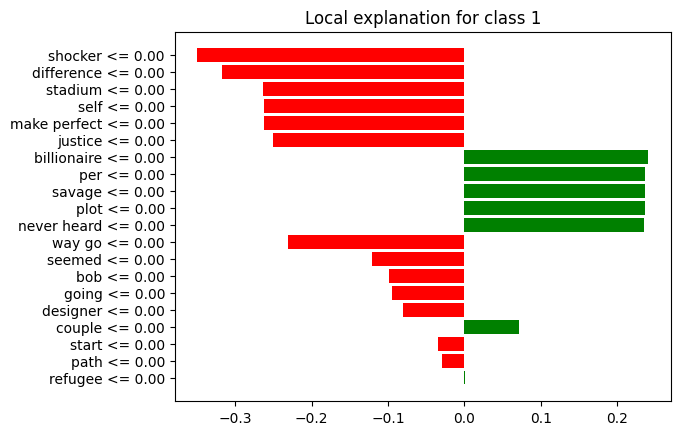

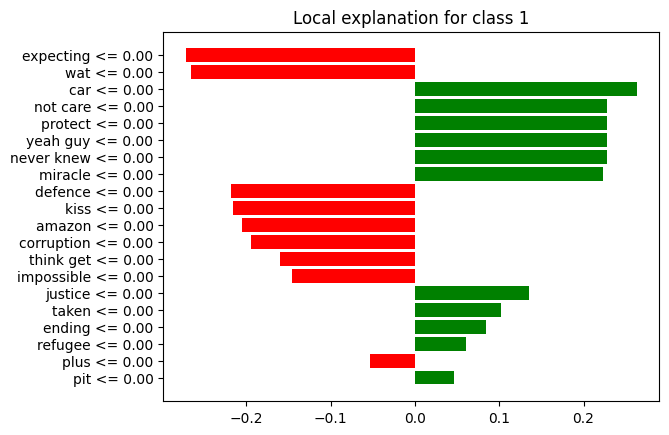

In [39]:

for idx_to_explain in [100,200,300]:
    data_to_explain = x_train[idx_to_explain]
    exp = explainer.explain_instance(
        data_row=data_to_explain,
        predict_fn=predict_fn,
        num_features=20,   # Limit to top 20 features
        num_samples=1000,
        distance_metric='cosine'
    )
    fig = exp.as_pyplot_figure()

    predicted_proba = ffmodel.predict(data_to_explain.reshape(1, -1))[0][0]
    print('Document ID: %d' % idx_to_explain)
    print('Document content: %s' % train["comment"][idx_to_explain])
    print('Probability(Sarcastic) =', predicted_proba)
    print('True class: %s' % y_train[idx_to_explain])

using iterative hyperparameter tuning

In [ ]:
from keras_tuner import HyperModel
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#use tf.keras.optimizers.legacy.Adam if on M1/M2 macbook
class MyHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        # First layer
        model.add(Dense(units=hp.Int('units_first', min_value=128, max_value=512, step=32),
                        activation='relu', input_dim=self.input_dim))
        model.add(Dropout(rate=hp.Float('dropout_first', min_value=0.1, max_value=0.5, step=0.1)))
        
        # Second layer
        model.add(Dense(units=hp.Int('units_second', min_value=64, max_value=256, step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_second', min_value=0.1, max_value=0.5, step=0.1)))

        # Third layer
        model.add(Dense(units=hp.Int('units_third', min_value=32, max_value=128, step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_third', min_value=0.1, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(1, activation='sigmoid'))

        # Tuning the learning rate
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

Using TensorFlow backend


In [ ]:
from kerastuner.tuners import Hyperband

hypermodel = MyHyperModel(input_dim=x_train.shape[1])

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='keras_tuner'
)
from tensorflow.keras.callbacks import EarlyStopping

stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train, y_train,
             epochs=50,
             validation_split=0.1,
             callbacks=[stop_early])


Reloading Tuner from keras_tuner_dir\keras_tuner\tuner0.json


C:\Users\cmz\AppData\Local\Temp\ipykernel_19772\215952752.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
# Summary of the best model
best_model.summary()
# Optionally, you can retrain the model with the best hyperparameters on the full dataset
#best_model.fit(x_train, y_train, epochs=10, batch_size=8, validation_split=0.1)
#y_pred_test = best_model.predict(x_test)
#roc_auc_test = roc_auc_score(y_test, y_pred_test)
#print(f'Best model AUC: {roc_auc_test}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 352)               2860000   
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                                 
 dense_4 (Dense)             (None, 160)               56480     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                10304     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

### RNN implementation

# Idea: 
- LSTM branch-> iteratively takes in comment tokens
- Dense branch-> dense layer takes in the other features
- Merge branches
- one more Dense layer


In [ ]:
rnn_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive', 'documents_comment']#, 'documents_parent_comment'] #if doesnt work we try comment_tfidf_nn
train["documents_comment"] = train['comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list)) #keras needs to use own tokenizer
#train["documents_parent_comment"] = train['parent_comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list))
test["documents_comment"] = test['comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list))
#test["documents_parent_comment"] = test['parent_comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list))

rnn_train = train[rnn_features]
rnn_test = test[rnn_features]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TextVectorization
from tensorflow.keras.models import Model


# TextVectorization for comment and parent_comment
max_features = 6000 #follow number of tokens for feedforward


vectorize_layer_comment = TextVectorization(
    max_tokens=max_features,
    split='whitespace',
    ngrams=3
    )
# Prepare dataset for TextVectorization adapt
train_texts = rnn_train['documents_comment'].tolist()
test_texts = rnn_test['documents_comment'].tolist()
vectorize_layer_comment.adapt(train_texts)

In [ ]:
from tensorflow.keras.layers import Embedding
#from tensorflow.keras.optimizers import Adam
#use tf.keras.optimizers.legacy.Adam if on M1/M2 macbook
# Assuming max_features is the vocabulary size and embedding_dim is the dimension of the embedding
embedding_dim = 128  # You can choose an appropriate value

# Add an Embedding layer after text vectorization
embedding_layer = Embedding(max_features, embedding_dim)

# LSTM Branch
text_input_comment = Input(shape=(1,), dtype=tf.string, name='text_comment')
text_features_comment = vectorize_layer_comment(text_input_comment)
text_features_comment = embedding_layer(text_features_comment)  # Embedding layer
lstm_comment = LSTM(64)(text_features_comment)

# Dense Features Branch
other_features_input = Input(shape=(len(rnn_features) - 1,), name='other_features')
dense_features = Dense(128, activation='relu')(other_features_input)

# Concatenate
concatenated = Concatenate()([lstm_comment, dense_features])

# Additional Dense Layers
output = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(output)

# Build Model
model = Model(inputs=[text_input_comment, other_features_input], outputs=output)
#optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
# Compile
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])#use Adam optimiser


In [ ]:

# Prepare text inputs
train_texts = np.array(train_texts)[:, np.newaxis]
test_texts = np.array(test_texts)[:, np.newaxis]

# Prepare other features inputs
feature_columns = [col for col in rnn_features if col != 'documents_comment']

train_other_features = np.array(rnn_train[feature_columns]).astype(np.float32)
test_other_features = np.array(rnn_test[feature_columns]).astype(np.float32)

# Fit the model
history = model.fit(
    [train_texts, train_other_features], y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1  # or use a validation set
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_texts, test_other_features], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
y_pred_probs = model.predict([test_texts, test_other_features]).ravel()

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc}")